# Traveling Salesman Problem Solved Genetic Algorithms with Crossover

The TSP is an old proverbial problem. A salesman with $K$ stopping points wants to find the most efficient route. The TSP essentially boils down to a combinatorial problem. We'd like to see every combination of solutions and choose the best. However, due to the nature of $K$ being usually large, testing every combination of possible routes can be very, very taxing in time and resources. 

There exist many articles discussing solutions to this problem:

- https://simple.wikipedia.org/wiki/Travelling_salesman_problem

- http://toddwschneider.com/posts/traveling-salesman-with-simulated-annealing-r-and-shiny/

- http://www.theprojectspot.com/tutorial-post/simulated-annealing-algorithm-for-beginners/6



In [1]:
import itertools as it
from tqdm import tqdm
import math

In [2]:

K = 15
print('Number of potential solutions', math.factorial(15))
points = list(range(K))
print(points)
#permutations = it.permutations(points, r = K)
#sum([1 for _ in tqdm(permutations)]) # 1,307,674,368,000

Number of potential solutions 1307674368000
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


## Genetic Algorithm

The algorithm we will follow is simple. Given a `fitness function`, $f(\cdot)$ we are trying to maximize, and for a certain number of generations, $N$, do the following

1. Initialize the population with randomly shuffled ordered paths; `parents`

2. Calculate the distance for each path in the population, then use this as the fitness function you are trying to minimize

    1. (Optional) Keep track of the fittest individual(s) throughout all generations

3. Sample the `parents` with sampling weights based on fitness (i.e. those with greater fitness have greater likelihood of being resampled); these will be used to create `children` for the next generation

    4. With some `mutation rate` mutate the `parents`

    5. (Optional) With some `crossover rate` select pairs of `parents` and randomly combine characteristics

4. The population from steps 4-5 become the `children` from the previous generation. Repeate steps 1-7.


### Suggestions for rearranging the path

One option is to choose two random points in the path (e.g. 2nd and 3rd points) and switch them, but a better approach is to select larger sections of the path and reverse the order such as

- e.g. path: 1,2,3,4,5,6,7,8,9,10 --> [4,3,2,1],5,6,7,8,9,10


## Crossover

[Crossover](http://www.obitko.com/tutorials/genetic-algorithms/crossover-mutation.php) in a genetic algorithm is the combination of characteristics between two parents to create new children. There are many strategies for performing crossover, but here we will use a specific strategy because crossover can cause errors in our solution search.

First, let's review what cross over may look like in our problem. In the TSP, we may have 5 locations, `[1,2,3,4,5]`. If we randomly select two members of our population, we may end up with the following

- parent 1: `[1,2,3,4,5]`
- parent 2: `[5,4,3,2,1]`
    
Using single point crossover, we could divide each into two sections, like

    [1,2,3 | ,4,5]
    [5,4,3 | ,2,1]
   
Then swap genes and combine the two to create new children


    [1,2,3  ,2,1] 
    [5,4,3  ,4,5] 

However, these two paths are invalid. They form an incomplete path and a cycle; the second child visits locations `4` and `5` twice, and the first child visits locations `1` and `2` twice. Thus, we'll have to be more creative in our crossover process.

I will use the following logic. Begin crossover as single point crossover, dividing each parent's genes into two,

    [1,2,3 | ,4,5]
    [5,4,3 | ,2,1]
    
Create the first child by keeping the first parent's gene's first half

- child 1: `[1, 2, 3 | _, _ ]`

Then, fill in the remaining space by taking the set difference between `child 1` and `parent 2`. The difference between `child 1` and `parent 2` is `[5, 4]`, *in that order*! So, we then complete `child 1`

- child 1: `[1, 2, 3 | 5, 4 ]`

The second child is created in the similar fashion. First obtain characteristics from the second parent, `parent 2`

- child 2: `[5,4,3 | _, _ ]`

Find the set difference between `child 2` and `parent 1`, and fill in the missing pieces. The difference here is `[1, 2]`

- child 2: `[5,4,3 | 1, 2 ]`

### References:

P. Larrañaga, C. M. H. Kuijpers, R. H. Murga, I. Inza, and S. Dizdarevic. 1999. Genetic Algorithms for the Travelling Salesman Problem: A Review of Representations and Operators. Artif. Intell. Rev. 13, 2 (April 1999), 129-170. DOI: https://doi.org/10.1023/A:1006529012972

## Set up

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
def gen_locations(seed=123, size=15):
    '''
    Generate (size=15) random locations
    '''
    np.random.seed(seed)
    x = np.random.randint(low = 1, high = 10+1, size = size)
    y = np.random.randint(low = 1, high = 10+1, size = size)
    return x,y


In [5]:
def distance(p1, p2):
    '''Returns Euclidean Distance between two points'''
    x1, y1 = p1
    x2, y2 = p2
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if d == 0:
        d = np.inf
    return d

In [6]:
def path_cost(path):
    start = path.pop() ## should be in order
    d = 0 # distance
    for p2 in reversed(path):
        d += distance(start, p2)
        print('{} --> {}: {}'.format(start, p2, round(d, 3)))
        start = p2
    return d

In [7]:
x,y = gen_locations(456,15) ## lowest distance 32.85
points = list(zip(x,y))

In [8]:
path_cost(points) # not accounting the trip back!

(5, 6) --> (9, 4): 4.472
(9, 4) --> (3, 4): 10.472
(3, 4) --> (3, 1): 13.472
(3, 1) --> (5, 1): 15.472
(5, 1) --> (3, 8): 22.752
(3, 8) --> (6, 7): 25.915
(6, 7) --> (4, 4): 29.52
(4, 4) --> (9, 3): 34.619
(9, 3) --> (2, 9): 43.839
(2, 9) --> (8, 10): 49.921
(8, 10) --> (6, 1): 59.141
(6, 1) --> (5, 7): 65.224
(5, 7) --> (10, 6): 70.323
(10, 6) --> (6, 9): 75.323


75.32272778228025

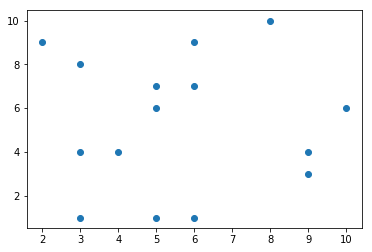

In [9]:
plt.scatter(x,y) ## lowest distance 32.85

In [10]:
class Path:
    def __init__(self, points):
        self.points = points # genes
        self._create_path() # ordered set of points
    
    def __repr__(self):
        return 'Path Distance: {}'.format(round(self.distance, 3))
    
    def __len__(self):
        return len(self.points)
    
    def __getitem__(self, item):
        return self.points[item]
    
    def copy(self):
        return Path(points = self.points)
        
    def _create_path(self, return_=False):
        points = self.points.copy()
        _init = points.pop(0) # get first item as start
        p1 = tuple(_init) # make copy; it will be end as well
        path = [p1]
        d = 0 # initial distance
        for p2 in points:
            path.append(p2) # save the points
            d += distance(p1, p2) # update the distance
            p1 = p2 # update current location 
        path.append(_init) ## start == end
        d += distance(p1, _init)
        self.path = path
        self.distance = d
        
        if return_:
            return d, path # return distance and path
    
    def plot(self, i=''):
        x,y = list(zip(*self.points))
        plt.scatter(x, y, marker='x')
        a,b = list(zip(*self.path))
        plt.plot(a,b)
        plt.title('{} Distnace: {}'.format(i,round(self.distance, 3)))

In [11]:
x,y = gen_locations(456,15) ## lowest distance 32.85
points = list(zip(x,y))
p = Path(points)
print('Initial', p)

Initial Path Distance: 78.485


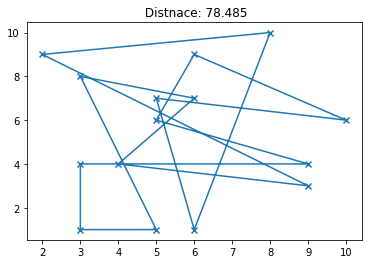

In [12]:
p.plot() # initial random potential route

## GA Solution

The GASolve module takes in the `points` for each location we need to visit, the population size `n`, and the rate of mutation, `mutation_rate`. Then, after the object is created, we can solve the problem using the `solve` function, which takes a number of generations as an argument, `generations`.

The function evolves the population over time by using the `_mutation` function. This function takes in the current population, `parents` to spawn new children which will have varying characteristics determined by a `mutation_rate`.

The traveling salesperson problem is essentially a minimization problem, where we want to minimize the total distance traveled. Thus, we need to find a fitness function that will return values that favor a minimizing value. I've chosen to use 

$$
f(distance) = \frac{1}{{distance}^{4}}
$$

So each unit in the population gets a weight $w = f(distance)$, and `_mutate` normalizes these weights by dividing each weight by the sum of all weights. I used the specific function above because I wanted to heavily weight those units that performed well. Here are the snippets of code where this is used

    weights = np.array([1/np.exp(path.distance) for path in parents]) # we want a smaller distance
    weights = weights / weights.sum() # normalize weights



Text(0,0.5,'Weights')

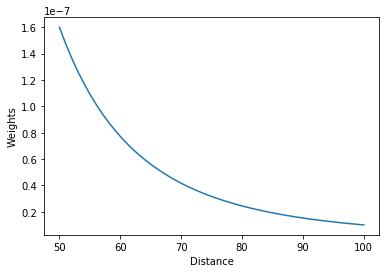

In [13]:
f = lambda x: 1 / (x**4)
x = np.linspace(50, 100) # distance
plt.plot(x, f(x))
plt.xlabel("Distance")
plt.ylabel("Weights")

In [14]:

class GASolve:
    def __init__(self, points, n, mutation_rate, crossover_rate):
        x, y = list(zip(*points))
        self.x = x 
        self.y = y
        self.points = points
        #self.decay = decay
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self._generate_parents(n)
        self.path = None
    
    def _sample(self):
        return random.sample(self.points, k=len(self.points))
    
    def _generate_parents(self, n):
        parents = []
        for _ in range(n):
            points = self._sample()
            parents.append(Path(points))
        self._init_parents = parents
    
    def resample(self, population):
        '''
        Resample the population based on fitness
        Returns parents selected by fitness
        '''
        k = len(population) 
        weights = np.array([1/(path.distance**4) for path in population]) # we want a smaller distance
        weights = weights / weights.sum()
        parents = random.choices(population=population, weights=weights, k = k)
        return parents
    
    def crossover(self, parents, crossover_rate):
        n = len(parents)//2 # number of couples, or pairs
        couples = zip(parents[:n], parents[n+1:]) # match up the couples
        children = []
        for p1, p2 in couples:
            if crossover_rate < random.random(): # crossover
                offspring = swap_genes(p1, p2)
                offspring = [Path(i) for i in offspring]
            else: # skip crossover
                offspring = [p1,p2]
            children.extend(offspring)
        return children
    
    def mutate(self, children, mutation_rate):
        ## sanity check
        LENGTHS = [len(child) for child in children]
        if min(LENGTHS) != max(LENGTHS):
            print('DIFFERENT LENGTHS', min(LENGTHS), max(LENGTHS))
        ## random mutation per child
        children = [_random_mutate(child, mutation_rate) for child in children]
        return children
    
    def solve(self, generations=10):
        population = self._init_parents
        
        print('\nFITTEST PARENTS')
        print('----------------')
        plt.ion()
        for i_ in range(generations):
            population.sort(key = lambda x: x.distance, reverse=False)
            best_ = population[0]
            print('Generation', i_,':', best_, '| Population Size:', len(population))
            plt.cla()
            
            if i_ % 10 == 0:
                best_.plot(i_)
                plt.pause(0.26)
            
            # create new generation
            parents = self.resample(population) # parents are randomly sampled; random order
            children = self.crossover(parents, self.crossover_rate)
            children = self.mutate(children, self.mutation_rate)
            population = children            
            
        population.sort(key = lambda x: x.distance, reverse=False)
        plt.ioff()
        #plt.show()
        plt.close()

        self.last_generation = population
        self.path = best_


In [15]:
def difference(A, B):
    '''
    Finds the difference between A and B
    Returns B units not in A
    '''
    return [i for i in B if i not in A]


In [16]:
def swap_genes(p1, p2):
    m = len(p1) //2
    child1 = p1[:m]
    diff = difference(child1,p2)
    child1 += list(diff)
    
    child2 = p2[:m]
    diff = difference(child2, p1)
    child2 += list(diff)
    
    return child1, child2


In [17]:
def _random_mutate(path, mutation_rate):
    '''
    For a unit in the population, 
    make a change to the characteristics based on mutation_rate
    '''
    if random.random() < mutation_rate:
        points = path.points.copy() # parent genes
        id1 = random.randint(0, len(points)-1)
        id2 = random.randint(0, len(points)-1)
        a, b = points[id1], points[id2]
        childgenes = points.copy()
        childgenes[id1] = b
        childgenes[id2] = a
        path = Path(childgenes)
    return path

Below, the algorithm will take in the `points` (cities), and generate `n=1000` random paths. I've set the mutation rate to be 0.35, so 35% of the population in each generation will have some mutation. You can play around with this value and how higher/lower mutation rates perform.

The `GASolve` class also has the ability to print out the performance and plot out every 10th iteration so you can see the progress.


FITTEST PARENTS
----------------
Generation 0 : Path Distance: 51.088 | Population Size: 1000


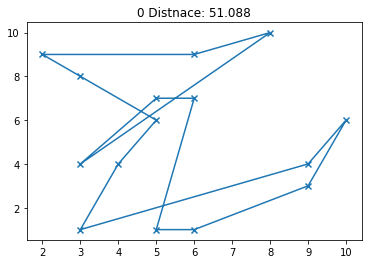

Generation 1 : Path Distance: 50.529 | Population Size: 998
Generation 2 : Path Distance: 50.067 | Population Size: 996
Generation 3 : Path Distance: 45.91 | Population Size: 994
Generation 4 : Path Distance: 46.303 | Population Size: 992
Generation 5 : Path Distance: 46.054 | Population Size: 990
Generation 6 : Path Distance: 43.311 | Population Size: 988
Generation 7 : Path Distance: 42.86 | Population Size: 986
Generation 8 : Path Distance: 42.86 | Population Size: 984
Generation 9 : Path Distance: 42.86 | Population Size: 982
Generation 10 : Path Distance: 42.402 | Population Size: 980


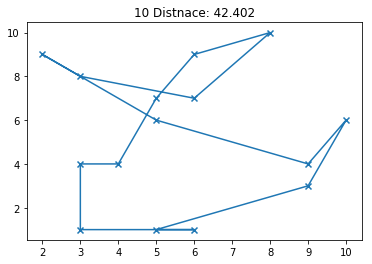

Generation 11 : Path Distance: 39.748 | Population Size: 978
Generation 12 : Path Distance: 39.748 | Population Size: 976
Generation 13 : Path Distance: 39.748 | Population Size: 974
Generation 14 : Path Distance: 39.748 | Population Size: 972
Generation 15 : Path Distance: 39.748 | Population Size: 970
Generation 16 : Path Distance: 39.748 | Population Size: 968
Generation 17 : Path Distance: 38.511 | Population Size: 966
Generation 18 : Path Distance: 37.757 | Population Size: 964
Generation 19 : Path Distance: 37.757 | Population Size: 962
Generation 20 : Path Distance: 37.757 | Population Size: 960


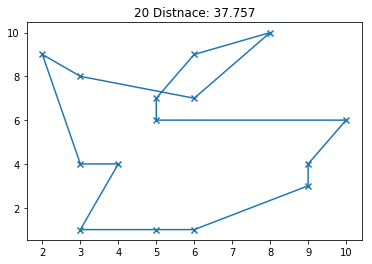

Generation 21 : Path Distance: 37.757 | Population Size: 958
Generation 22 : Path Distance: 36.645 | Population Size: 956
Generation 23 : Path Distance: 37.881 | Population Size: 954
Generation 24 : Path Distance: 37.262 | Population Size: 952
Generation 25 : Path Distance: 37.77 | Population Size: 950
Generation 26 : Path Distance: 37.77 | Population Size: 948
Generation 27 : Path Distance: 37.757 | Population Size: 946
Generation 28 : Path Distance: 36.645 | Population Size: 944
Generation 29 : Path Distance: 36.645 | Population Size: 942
Generation 30 : Path Distance: 36.521 | Population Size: 940


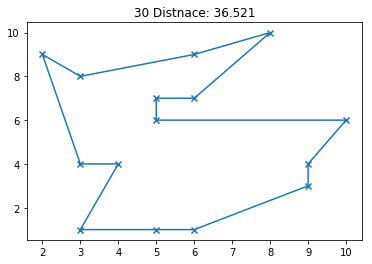

Generation 31 : Path Distance: 36.521 | Population Size: 938
Generation 32 : Path Distance: 36.521 | Population Size: 936
Generation 33 : Path Distance: 36.521 | Population Size: 934
Generation 34 : Path Distance: 34.828 | Population Size: 932
Generation 35 : Path Distance: 34.828 | Population Size: 930
Generation 36 : Path Distance: 34.828 | Population Size: 928
Generation 37 : Path Distance: 34.828 | Population Size: 926
Generation 38 : Path Distance: 34.704 | Population Size: 924
Generation 39 : Path Distance: 34.704 | Population Size: 922
Generation 40 : Path Distance: 34.704 | Population Size: 920


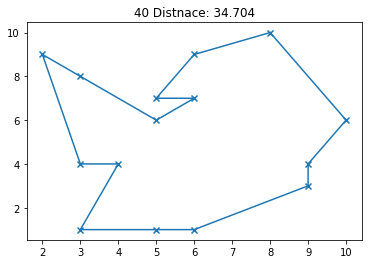

Generation 41 : Path Distance: 33.679 | Population Size: 918
Generation 42 : Path Distance: 34.737 | Population Size: 916
Generation 43 : Path Distance: 34.704 | Population Size: 914
Generation 44 : Path Distance: 34.704 | Population Size: 912
Generation 45 : Path Distance: 34.704 | Population Size: 910
Generation 46 : Path Distance: 34.704 | Population Size: 908
Generation 47 : Path Distance: 34.704 | Population Size: 906
Generation 48 : Path Distance: 33.876 | Population Size: 904
Generation 49 : Path Distance: 33.876 | Population Size: 902
Generation 50 : Path Distance: 33.876 | Population Size: 900


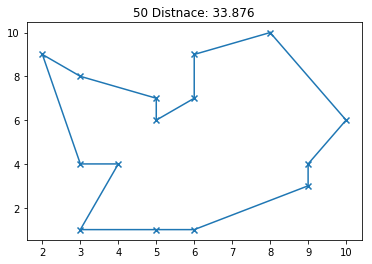

Generation 51 : Path Distance: 33.876 | Population Size: 898
Generation 52 : Path Distance: 34.33 | Population Size: 896
Generation 53 : Path Distance: 34.369 | Population Size: 894
Generation 54 : Path Distance: 34.369 | Population Size: 892
Generation 55 : Path Distance: 34.054 | Population Size: 890
Generation 56 : Path Distance: 34.704 | Population Size: 888
Generation 57 : Path Distance: 34.054 | Population Size: 886
Generation 58 : Path Distance: 34.178 | Population Size: 884
Generation 59 : Path Distance: 34.178 | Population Size: 882
Generation 60 : Path Distance: 34.178 | Population Size: 880


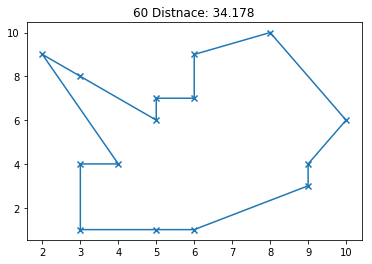

Generation 61 : Path Distance: 33.835 | Population Size: 878
Generation 62 : Path Distance: 33.634 | Population Size: 876
Generation 63 : Path Distance: 33.634 | Population Size: 874
Generation 64 : Path Distance: 33.634 | Population Size: 872
Generation 65 : Path Distance: 33.634 | Population Size: 870
Generation 66 : Path Distance: 33.634 | Population Size: 868
Generation 67 : Path Distance: 33.634 | Population Size: 866
Generation 68 : Path Distance: 33.634 | Population Size: 864
Generation 69 : Path Distance: 32.85 | Population Size: 862
Generation 70 : Path Distance: 32.85 | Population Size: 860


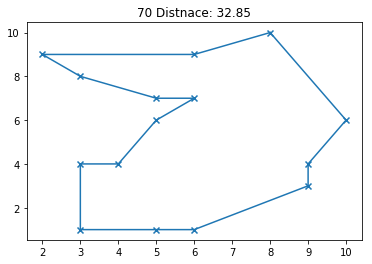

Generation 71 : Path Distance: 33.634 | Population Size: 858
Generation 72 : Path Distance: 33.634 | Population Size: 856
Generation 73 : Path Distance: 33.634 | Population Size: 854
Generation 74 : Path Distance: 33.634 | Population Size: 852
Generation 75 : Path Distance: 33.634 | Population Size: 850
Generation 76 : Path Distance: 33.634 | Population Size: 848
Generation 77 : Path Distance: 33.634 | Population Size: 846
Generation 78 : Path Distance: 33.634 | Population Size: 844
Generation 79 : Path Distance: 33.634 | Population Size: 842
Generation 80 : Path Distance: 33.634 | Population Size: 840


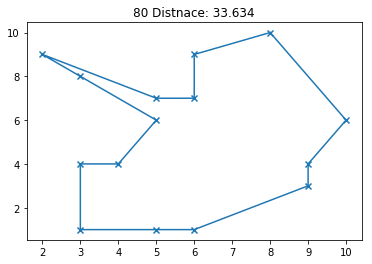

Generation 81 : Path Distance: 33.634 | Population Size: 838
Generation 82 : Path Distance: 33.634 | Population Size: 836
Generation 83 : Path Distance: 33.634 | Population Size: 834
Generation 84 : Path Distance: 33.634 | Population Size: 832
Generation 85 : Path Distance: 33.634 | Population Size: 830
Generation 86 : Path Distance: 33.634 | Population Size: 828
Generation 87 : Path Distance: 33.634 | Population Size: 826
Generation 88 : Path Distance: 33.634 | Population Size: 824
Generation 89 : Path Distance: 33.634 | Population Size: 822
Generation 90 : Path Distance: 33.634 | Population Size: 820


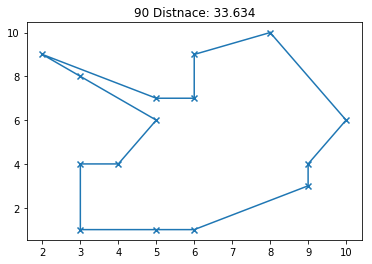

Generation 91 : Path Distance: 33.634 | Population Size: 818
Generation 92 : Path Distance: 33.634 | Population Size: 816
Generation 93 : Path Distance: 33.634 | Population Size: 814
Generation 94 : Path Distance: 33.634 | Population Size: 812
Generation 95 : Path Distance: 33.634 | Population Size: 810
Generation 96 : Path Distance: 33.634 | Population Size: 808
Generation 97 : Path Distance: 33.634 | Population Size: 806
Generation 98 : Path Distance: 33.634 | Population Size: 804
Generation 99 : Path Distance: 33.634 | Population Size: 802
Generation 100 : Path Distance: 33.634 | Population Size: 800


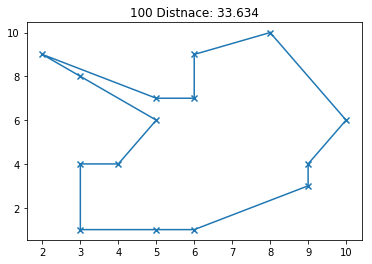

Generation 101 : Path Distance: 33.634 | Population Size: 798
Generation 102 : Path Distance: 33.634 | Population Size: 796
Generation 103 : Path Distance: 33.634 | Population Size: 794
Generation 104 : Path Distance: 33.362 | Population Size: 792
Generation 105 : Path Distance: 33.634 | Population Size: 790
Generation 106 : Path Distance: 33.634 | Population Size: 788
Generation 107 : Path Distance: 33.634 | Population Size: 786
Generation 108 : Path Distance: 33.634 | Population Size: 784
Generation 109 : Path Distance: 33.634 | Population Size: 782
Generation 110 : Path Distance: 33.634 | Population Size: 780


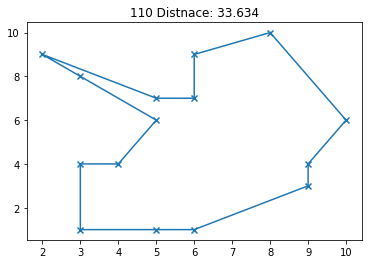

Generation 111 : Path Distance: 33.634 | Population Size: 778
Generation 112 : Path Distance: 33.634 | Population Size: 776
Generation 113 : Path Distance: 33.634 | Population Size: 774
Generation 114 : Path Distance: 33.634 | Population Size: 772
Generation 115 : Path Distance: 33.634 | Population Size: 770
Generation 116 : Path Distance: 33.634 | Population Size: 768
Generation 117 : Path Distance: 33.634 | Population Size: 766
Generation 118 : Path Distance: 33.634 | Population Size: 764
Generation 119 : Path Distance: 33.634 | Population Size: 762
Generation 120 : Path Distance: 33.634 | Population Size: 760


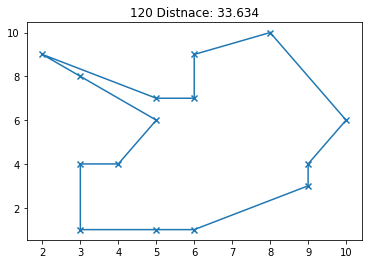

Generation 121 : Path Distance: 33.634 | Population Size: 758
Generation 122 : Path Distance: 33.634 | Population Size: 756
Generation 123 : Path Distance: 33.634 | Population Size: 754
Generation 124 : Path Distance: 33.634 | Population Size: 752
Generation 125 : Path Distance: 33.634 | Population Size: 750
Generation 126 : Path Distance: 33.634 | Population Size: 748
Generation 127 : Path Distance: 33.634 | Population Size: 746
Generation 128 : Path Distance: 33.634 | Population Size: 744
Generation 129 : Path Distance: 33.634 | Population Size: 742
Generation 130 : Path Distance: 33.634 | Population Size: 740


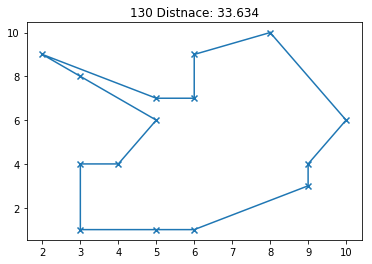

Generation 131 : Path Distance: 33.634 | Population Size: 738
Generation 132 : Path Distance: 33.634 | Population Size: 736
Generation 133 : Path Distance: 33.634 | Population Size: 734
Generation 134 : Path Distance: 33.634 | Population Size: 732
Generation 135 : Path Distance: 33.634 | Population Size: 730
Generation 136 : Path Distance: 33.634 | Population Size: 728
Generation 137 : Path Distance: 33.634 | Population Size: 726
Generation 138 : Path Distance: 33.634 | Population Size: 724
Generation 139 : Path Distance: 33.634 | Population Size: 722
Generation 140 : Path Distance: 33.634 | Population Size: 720


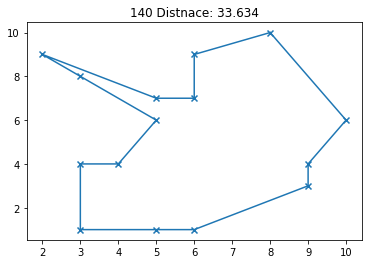

Generation 141 : Path Distance: 33.634 | Population Size: 718
Generation 142 : Path Distance: 33.634 | Population Size: 716
Generation 143 : Path Distance: 33.634 | Population Size: 714
Generation 144 : Path Distance: 33.634 | Population Size: 712
Generation 145 : Path Distance: 33.634 | Population Size: 710
Generation 146 : Path Distance: 33.634 | Population Size: 708
Generation 147 : Path Distance: 33.634 | Population Size: 706
Generation 148 : Path Distance: 33.634 | Population Size: 704
Generation 149 : Path Distance: 33.634 | Population Size: 702
Generation 150 : Path Distance: 33.634 | Population Size: 700


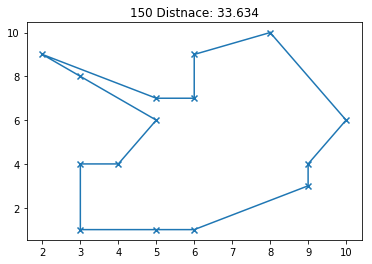

Generation 151 : Path Distance: 33.634 | Population Size: 698
Generation 152 : Path Distance: 33.634 | Population Size: 696
Generation 153 : Path Distance: 33.634 | Population Size: 694
Generation 154 : Path Distance: 33.634 | Population Size: 692
Generation 155 : Path Distance: 33.634 | Population Size: 690
Generation 156 : Path Distance: 33.634 | Population Size: 688
Generation 157 : Path Distance: 33.634 | Population Size: 686
Generation 158 : Path Distance: 33.634 | Population Size: 684
Generation 159 : Path Distance: 33.634 | Population Size: 682
Generation 160 : Path Distance: 33.634 | Population Size: 680


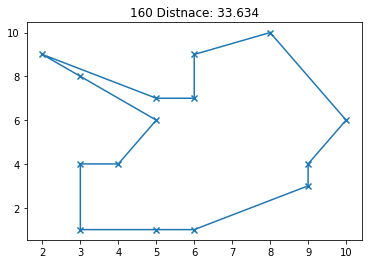

Generation 161 : Path Distance: 33.634 | Population Size: 678
Generation 162 : Path Distance: 33.634 | Population Size: 676
Generation 163 : Path Distance: 33.634 | Population Size: 674
Generation 164 : Path Distance: 33.634 | Population Size: 672
Generation 165 : Path Distance: 33.362 | Population Size: 670
Generation 166 : Path Distance: 33.362 | Population Size: 668
Generation 167 : Path Distance: 33.634 | Population Size: 666
Generation 168 : Path Distance: 33.634 | Population Size: 664
Generation 169 : Path Distance: 33.634 | Population Size: 662
Generation 170 : Path Distance: 33.634 | Population Size: 660


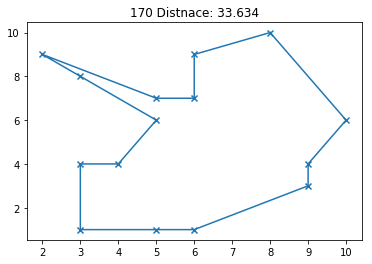

Generation 171 : Path Distance: 33.634 | Population Size: 658
Generation 172 : Path Distance: 33.634 | Population Size: 656
Generation 173 : Path Distance: 33.362 | Population Size: 654
Generation 174 : Path Distance: 33.634 | Population Size: 652
Generation 175 : Path Distance: 33.634 | Population Size: 650
Generation 176 : Path Distance: 33.634 | Population Size: 648
Generation 177 : Path Distance: 33.634 | Population Size: 646
Generation 178 : Path Distance: 33.362 | Population Size: 644
Generation 179 : Path Distance: 33.634 | Population Size: 642
Generation 180 : Path Distance: 33.634 | Population Size: 640


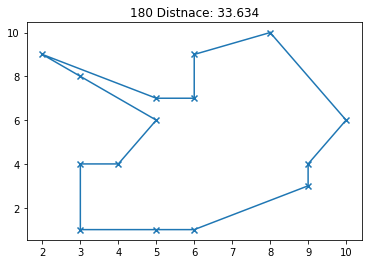

Generation 181 : Path Distance: 33.634 | Population Size: 638
Generation 182 : Path Distance: 33.634 | Population Size: 636
Generation 183 : Path Distance: 33.634 | Population Size: 634
Generation 184 : Path Distance: 33.634 | Population Size: 632
Generation 185 : Path Distance: 33.605 | Population Size: 630
Generation 186 : Path Distance: 32.85 | Population Size: 628
Generation 187 : Path Distance: 32.85 | Population Size: 626
Generation 188 : Path Distance: 32.85 | Population Size: 624
Generation 189 : Path Distance: 32.85 | Population Size: 622
Generation 190 : Path Distance: 32.85 | Population Size: 620


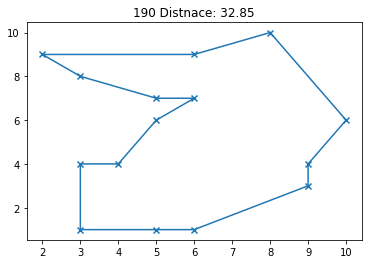

Generation 191 : Path Distance: 32.85 | Population Size: 618
Generation 192 : Path Distance: 32.85 | Population Size: 616
Generation 193 : Path Distance: 32.85 | Population Size: 614
Generation 194 : Path Distance: 32.85 | Population Size: 612
Generation 195 : Path Distance: 32.85 | Population Size: 610
Generation 196 : Path Distance: 32.85 | Population Size: 608
Generation 197 : Path Distance: 32.85 | Population Size: 606
Generation 198 : Path Distance: 32.85 | Population Size: 604
Generation 199 : Path Distance: 32.85 | Population Size: 602


In [18]:
ga = GASolve(points, n=1000, mutation_rate=0.4, crossover_rate = 0.3)
ga.solve(generations=200)

Solution Path Distance: 32.85
[(8, 10), (6, 9), (2, 9), (3, 8), (5, 7), (6, 7), (5, 6), (4, 4), (3, 4), (3, 1), (5, 1), (6, 1), (9, 3), (9, 4), (10, 6), (8, 10)]


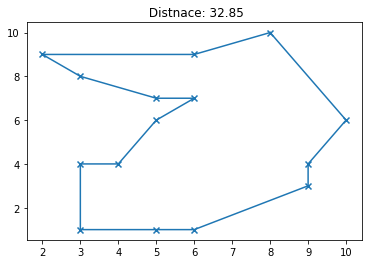

In [19]:
solution = ga.path
solution.plot()
print('Solution', solution)
print(str(solution.path))
plt.show()

## Reference:

S. Lin, ["Computer solutions of the traveling salesman problem,"](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6767727&isnumber=6767724) in The Bell System Technical Journal, vol. 44, no. 10, pp. 2245-2269, Dec. 1965.
doi: 10.1002/j.1538-7305.1965.tb04146.x
Abstract: Two algorithms for solving the (symmetric distance) traveling salesman problem have been programmed for a high-speed digital computer. The first produces guaranteed optimal solution for problems involving no more than 13 cities; the time required (IBM 7094 II) varies from 60 milliseconds for a 9-city problem to 1.75 seconds for a 13-city problem. The second algorithm produces precisely characterized, locally optimal solutions for large problems (up to 145 cities) in an extremely short time and is based on a general heuristic approach believed to be of general applicability to various optimization problems. The average time required to obtain a locally optimal solution is under 30n3 microseconds where n is the number of cities involved. Repeated runs on a problem from random initial tours result in a high probability of finding the optimal solution among the locally optimal solutions obtained. For large problems where many locally optimal solutions have to be obtained in order to be reasonably assured of having the optimal solution, an efficient reduction scheme is incorporated in the program to reduce the total computation time by a substantial amount.